<a href="https://colab.research.google.com/github/iamajayraj/Stock-Price-Prediction/blob/master/stock_price_prediction_using_stackedLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping

In [39]:
df= pd.read_csv("/content/SBIN.NS.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,18.691147,18.978922,18.540184,18.823240,12.409932,43733533.0
1,1996-01-02,18.894005,18.964767,17.738192,18.224106,12.014932,56167280.0
2,1996-01-03,18.327892,18.568489,17.643839,17.738192,11.694572,68296318.0
3,1996-01-04,17.502312,17.832542,17.223972,17.676863,11.654138,86073880.0
4,1996-01-05,17.738192,17.785366,17.459852,17.577793,11.588826,76613039.0
...,...,...,...,...,...,...,...
7007,2023-11-03,576.000000,579.500000,573.450012,578.150024,578.150024,11371371.0
7008,2023-11-06,582.000000,582.500000,573.250000,574.349976,574.349976,16499138.0
7009,2023-11-07,574.799988,581.200012,572.599976,579.750000,579.750000,17923281.0
7010,2023-11-08,581.900024,582.599976,579.000000,580.299988,580.299988,15434808.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7012 non-null   object 
 1   Open       7003 non-null   float64
 2   High       7003 non-null   float64
 3   Low        7003 non-null   float64
 4   Close      7003 non-null   float64
 5   Adj Close  7003 non-null   float64
 6   Volume     7003 non-null   float64
dtypes: float64(6), object(1)
memory usage: 383.6+ KB


In [41]:
#very few nan values so we drop them
df = df.dropna()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,18.691147,18.978922,18.540184,18.823240,12.409932,43733533.0
1,1996-01-02,18.894005,18.964767,17.738192,18.224106,12.014932,56167280.0
2,1996-01-03,18.327892,18.568489,17.643839,17.738192,11.694572,68296318.0
3,1996-01-04,17.502312,17.832542,17.223972,17.676863,11.654138,86073880.0
4,1996-01-05,17.738192,17.785366,17.459852,17.577793,11.588826,76613039.0
...,...,...,...,...,...,...,...
7007,2023-11-03,576.000000,579.500000,573.450012,578.150024,578.150024,11371371.0
7008,2023-11-06,582.000000,582.500000,573.250000,574.349976,574.349976,16499138.0
7009,2023-11-07,574.799988,581.200012,572.599976,579.750000,579.750000,17923281.0
7010,2023-11-08,581.900024,582.599976,579.000000,580.299988,580.299988,15434808.0


In [42]:
#we try to predict the opening price for next day, this can be done for High,Low,Close,Adj Close and Volume also
open_series=df['Open']
open_series

0        18.691147
1        18.894005
2        18.327892
3        17.502312
4        17.738192
           ...    
7007    576.000000
7008    582.000000
7009    574.799988
7010    581.900024
7011    581.000000
Name: Open, Length: 7003, dtype: float64

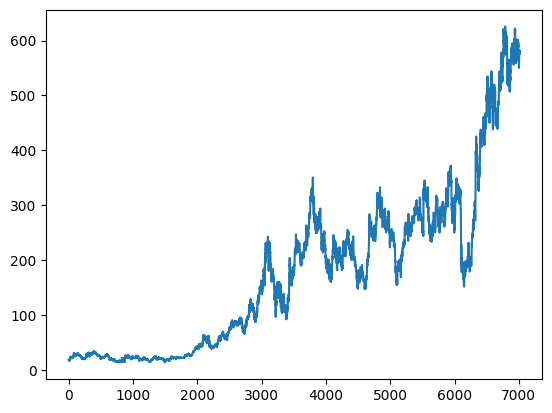

In [43]:
plt.plot(open_series)

In [44]:
#Since LSTM is sensitive to the scale of the data, we apply MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
open_array=scaler.fit_transform(np.array(open_series).reshape(-1,1))
open_array

array([[0.0085169 ],
       [0.00884832],
       [0.00792341],
       ...,
       [0.91708489],
       [0.9286849 ],
       [0.92721444]])

In [45]:
#Now, we split the data into training and testing set
training_size= int(len(open_array)*0.80)
training_size

5602

In [46]:
test_size=len(open_array)-training_size
test_size

1401

In [47]:
training_data=open_array[:training_size,:]
training_data

array([[0.0085169 ],
       [0.00884832],
       [0.00792341],
       ...,
       [0.39467888],
       [0.38152682],
       [0.39786477]])

In [48]:
test_data=open_array[training_size:len(open_array),:1]
test_data

array([[0.39312678],
       [0.38855214],
       [0.39051269],
       ...,
       [0.91708489],
       [0.9286849 ],
       [0.92721444]])

In [49]:
#Now we create a input dataset for LSTM, for each new prediction we want LSTM to consider previous 50 values.
def create_dataset(dataset, time_step=50):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----49   50
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [50]:
# reshape into X=t,t+1,t+2,t+3...t+49 and Y=t+50
time_step = 50
X_train, y_train = create_dataset(training_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5551, 50)
(5551,)
(1350, 50)
(1350,)


In [52]:
#The LSTM recieves the input in the format (training_size,time_step,No_of_features)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [53]:
print(X_train.shape)
print(X_test.shape)

(5551, 50, 1)
(1350, 50, 1)


In [54]:
#Stacked_LSTM model
model = Sequential()
model.add(LSTM(50,kernel_regularizer=l2(0.1),return_sequences=True,input_shape=(50,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,kernel_regularizer=l2(0.1),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 5085

In [56]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=50,verbose=1)

Epoch 1/50
112/112 [==============================] - 7s 23ms/step - loss: 3.1972 - val_loss: 0.6316
Epoch 2/50
112/112 [==============================] - 2s 17ms/step - loss: 0.1945 - val_loss: 0.0599
Epoch 3/50
112/112 [==============================] - 2s 14ms/step - loss: 0.0077 - val_loss: 0.0398
Epoch 4/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0498
Epoch 5/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0533
Epoch 6/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0492
Epoch 7/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0696
Epoch 8/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0517
Epoch 9/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0312
Epoch 10/50
112/112 [==============================] - 1s 11ms/step - loss: 0.0022 - val_lo

In [57]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

43/43 [==============================] - 0s 6ms/step


In [58]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [59]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

154.66027587316458

In [60]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

326.779921229813

In [61]:
#Now, we create a dataframe b/w actual and predicted values
test_predict.reshape(1350,)

array([241.11736, 240.86185, 240.46974, ..., 421.18304, 420.56317,
       419.94757], dtype=float32)

In [62]:
#Starts from 51 beacuse first 50 values were used to predict 51st value
scaler.inverse_transform(test_data[51:]).reshape(1350,)

array([267.799988, 267.399994, 270.5     , ..., 574.799988, 581.900024,
       581.      ])

In [63]:
df["Date"][training_size+51:].values

array(['2018-05-25', '2018-05-28', '2018-05-29', ..., '2023-11-07',
       '2023-11-08', '2023-11-09'], dtype=object)

In [64]:
df_dict={'Date':df["Date"][training_size+51:].values,"Actual":scaler.inverse_transform(test_data[51:]).reshape(1350,),"Predicted":test_predict.reshape(1350,)}

In [65]:
pd.DataFrame(df_dict)

,Date,Actual,Predicted
0,2018-05-25,267.799988,241.117355
1,2018-05-28,267.399994,240.861847
2,2018-05-29,270.500000,240.469742
3,2018-05-30,260.500000,240.121353
4,2018-05-31,266.850006,239.972885
...,...,...,...
1345,2023-11-03,576.000000,421.988678
1346,2023-11-06,582.000000,421.653748
1347,2023-11-07,574.799988,421.183044
1348,2023-11-08,581.900024,420.563171


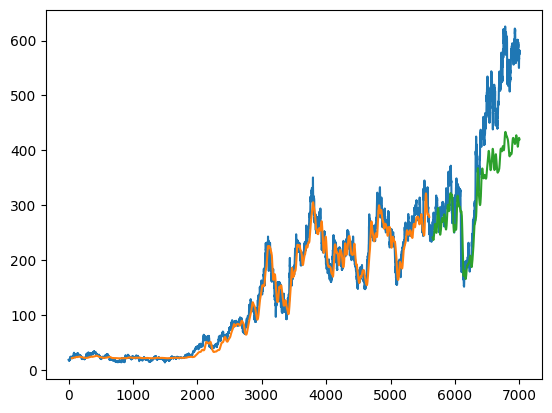

In [66]:
#Now, plotting the predictions
look_back=50
trainPredictPlot = np.empty_like(open_array)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(open_array)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(open_array)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(open_array))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [67]:
#Last date in our data is 9/11/2023 , To predict value for 10/11/2023 we need last 50 days value
open_array

array([[0.0085169 ],
       [0.00884832],
       [0.00792341],
       ...,
       [0.91708489],
       [0.9286849 ],
       [0.92721444]])

In [68]:
open_array.shape

(7003, 1)

In [69]:
input_10Nov=open_array[open_array.shape[0]-50:,:]

In [70]:
input_10Nov.reshape(1,-1)

array([[0.91520608, 0.92018914, 0.90809902, 0.89731601, 0.91251028,
        0.91839191, 0.91618632, 0.9059751 , 0.92721444, 0.93701721,
        0.94788199, 0.93930456, 0.95572419, 0.95719454, 0.95629598,
        0.95964524, 0.95825655, 0.94763688, 0.96070724, 0.94845378,
        0.94755521, 0.94396084, 0.94657488, 0.95270161, 0.95825655,
        0.9419186 , 0.94747354, 0.93865101, 0.93701721, 0.95319182,
        0.94322561, 0.92190461, 0.91904546, 0.92182294, 0.92190461,
        0.90891591, 0.90907935, 0.89796947, 0.89061739, 0.87893581,
        0.87656679, 0.89780613, 0.90434131, 0.90311596, 0.91103983,
        0.91904546, 0.92884824, 0.91708489, 0.9286849 , 0.92721444]])

In [71]:
model.predict(input_10Nov.reshape((1,50,1)),verbose=0)

array([[0.6612944]], dtype=float32)

In [72]:
scaler.inverse_transform(model.predict(input_10Nov.reshape((1,50,1)),verbose=0))

array([[418.23785]], dtype=float32)